## Import librarys and functions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import numpy as np
from functions import *

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    # Get the name of the current GPU
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    
    # Get the capability/properties
    print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")
    
    # Print the device object being used in your code
    print(f"Current Device: {device}")
else:
    print("CUDA is not available. Using CPU.")
    

Using device: cuda
GPU Name: NVIDIA A30
GPU Capability: (8, 0)
Current Device: cuda


## Generate a grid

In [3]:
num_points_theta = 200
num_points_r = 200
internal_radius =1
external_radius=10
theta_max=1*torch.pi
#50 points each works with 2 layers 50 perceptrons and radius 5 external
R, Theta, r_values,theta_values, X, Z = generate_grid(num_points_theta,num_points_r,internal_radius, external_radius, theta_max)


print(R.shape)

torch.Size([40000])


/home/jovyan/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/jovyan/Arash/Hyperparameter tuning/Data=0.7Phy=0.3/functions_hills_spherical.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R=torch.tensor(R, dtype=torch.float32, requires_grad=True)
/home/jovyan/Arash/Hyperparameter tuning/Data=0.7Phy=0.3/functions_hills_spherical.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Theta=torch.tensor(Theta, dtype=torch.float3

In [4]:
# phi_index = torch.argmin(torch.abs(Phi[0, 0, :]))

# R = R[:, :, phi_index]
# Theta = Theta[:, :, phi_index]
# R=R.flatten()#.unsqueeze(1)
# Theta=Theta.flatten()#.unsqueeze(1)



## Plot grid

In [5]:
R_theta=torch.stack([R, Theta], dim=1)
x_data=torch.tensor(R_theta,dtype=torch.float32, requires_grad=True)
x_data = x_data.to(device).clone().detach()
x_data.requires_grad_(True)
print(x_data.shape)

/tmp/ipykernel_1226577/1469569247.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_data=torch.tensor(R_theta,dtype=torch.float32, requires_grad=True)


torch.Size([40000, 2])


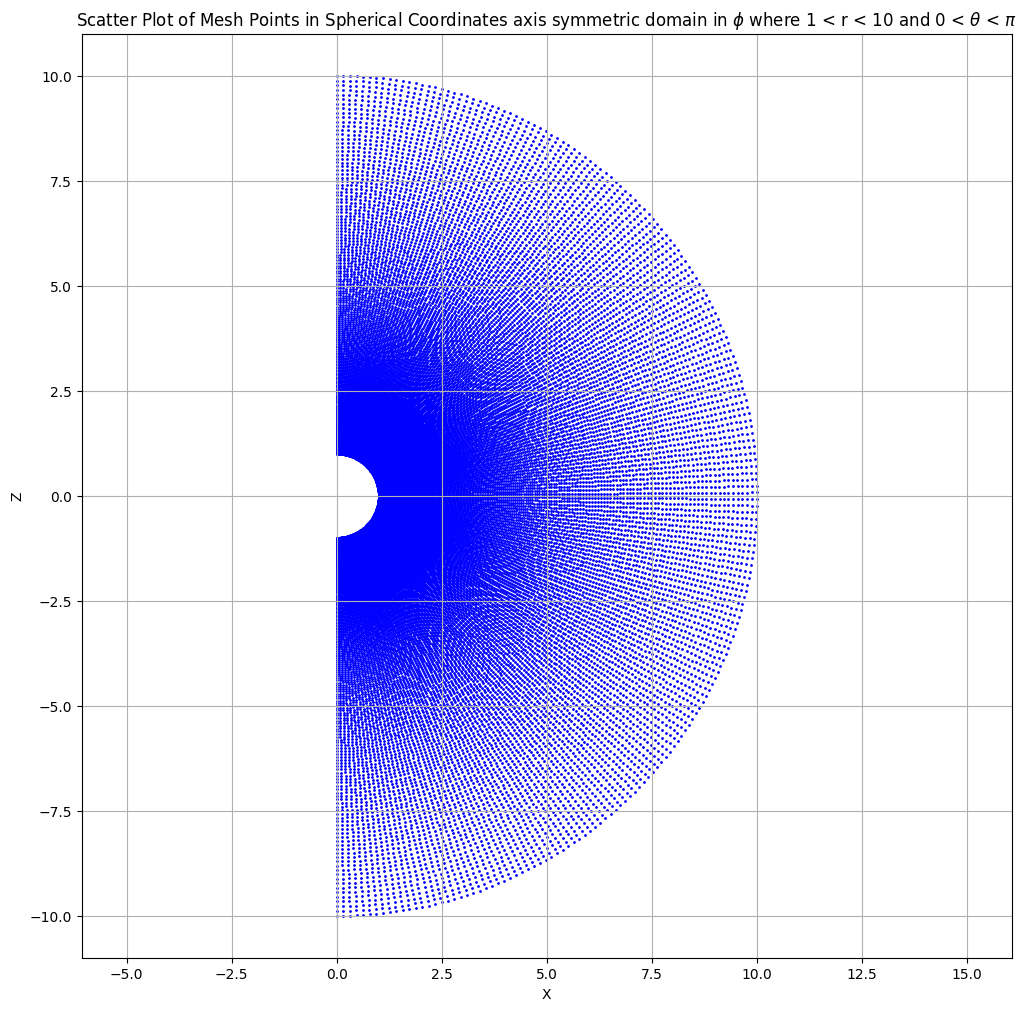

In [6]:
# Create scatter plot
plt.figure(figsize=(12, 12))  # Equal aspect ratio
plt.scatter(X.flatten(), Z.flatten(), s=1, color='b', marker='o')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Z')
plt.title(r'Scatter Plot of Mesh Points in Spherical Coordinates axis symmetric domain in $\phi$ where 1 < r < 10 and 0 < $\theta$ < $\pi$')
plt.grid(True)
plt.show()

## Velocity field

In [7]:
u_x,u_z,V_theta,V_r,V,psi=sphere_velocity_field(R,Theta)
noise_level=0.5
#Add noise
V_r_noise= V_r +noise_level * torch.randn_like(V_r)
V_theta_noise= V_theta +noise_level * torch.randn_like(V_theta)
u_x_noise = V_r_noise * torch.sin(Theta) + V_theta_noise * torch.cos(Theta)
u_z_noise = V_r_noise * torch.cos(Theta) - V_theta_noise * torch.sin(Theta)

V_noise= torch.sqrt(u_x_noise**2+u_z_noise**2)

print(V_r)
print(Theta)
print(torch.max(V_r))
print(torch.min(V_r))
print(V_theta)
print(torch.max(V_theta))
print(torch.min(V_theta))
V_r_noise=V_r_noise.to(device).clone().detach()
V_theta_noise=V_theta_noise.to(device).clone().detach()

tensor([-0.0000, -0.0000, -0.0000,  ..., -0.9985, -0.9989, -0.9990],
       grad_fn=<DivBackward0>)
tensor([1.0000e-04, 1.5886e-02, 3.1673e-02,  ..., 3.1100e+00, 3.1258e+00,
        3.1416e+00], grad_fn=<ReshapeAliasBackward0>)
tensor(0.9990, grad_fn=<MaxBackward1>)
tensor(-0.9990, grad_fn=<MinBackward1>)
tensor([-1.5000e-04, -2.3829e-02, -4.7501e-02,  ..., -3.1583e-02,
        -1.5794e-02,  8.7466e-08], grad_fn=<DivBackward0>)
tensor(1.3113e-07, grad_fn=<MaxBackward1>)
tensor(-1.5000, grad_fn=<MinBackward1>)


## Plot velocity field

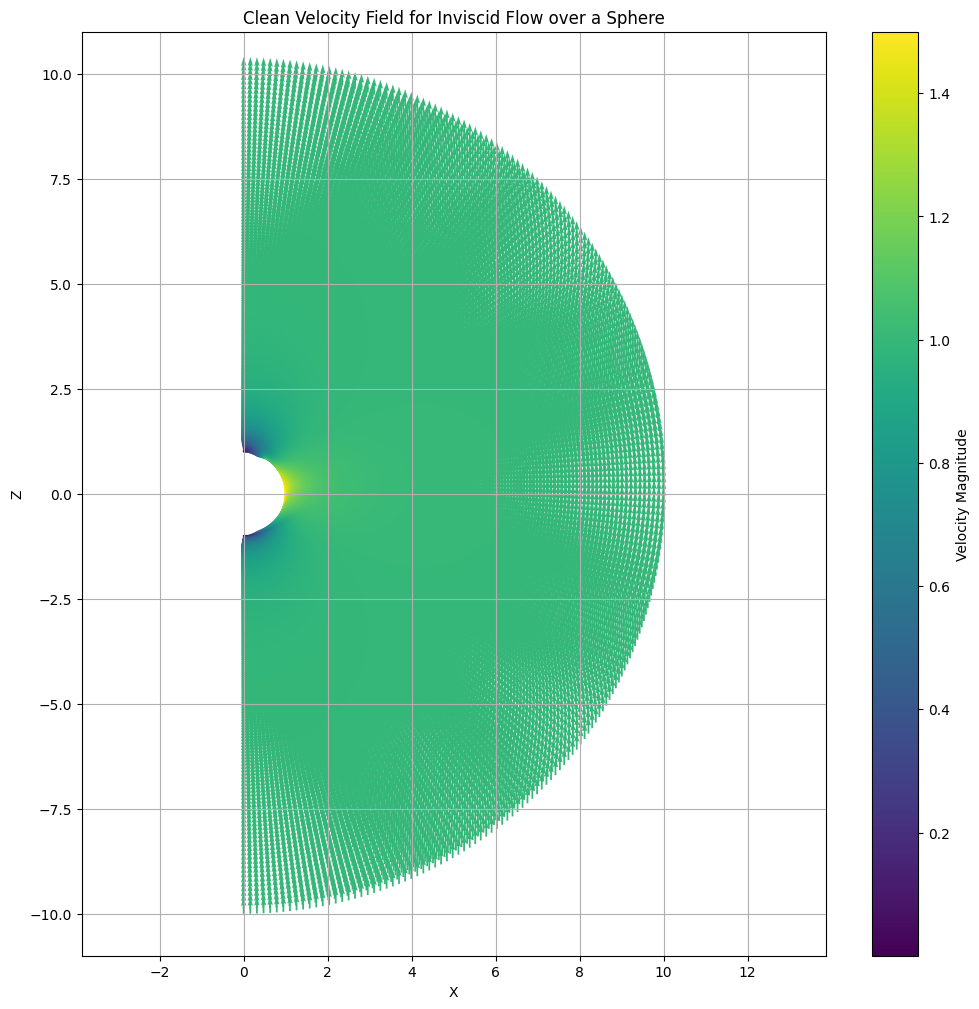

In [8]:
plt.figure(figsize=(12, 12))
plt.quiver(X.detach().numpy(), Z.detach().numpy(), u_x.detach().numpy(), u_z.detach().numpy(), V.detach().numpy(),angles='xy', scale_units='xy', scale=2.5, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Clean Velocity Field for Inviscid Flow over a Sphere')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Velocity Magnitude")
plt.show()


(-8.74227794156468e-07, 9.999692916870117, -10.0, 10.0)

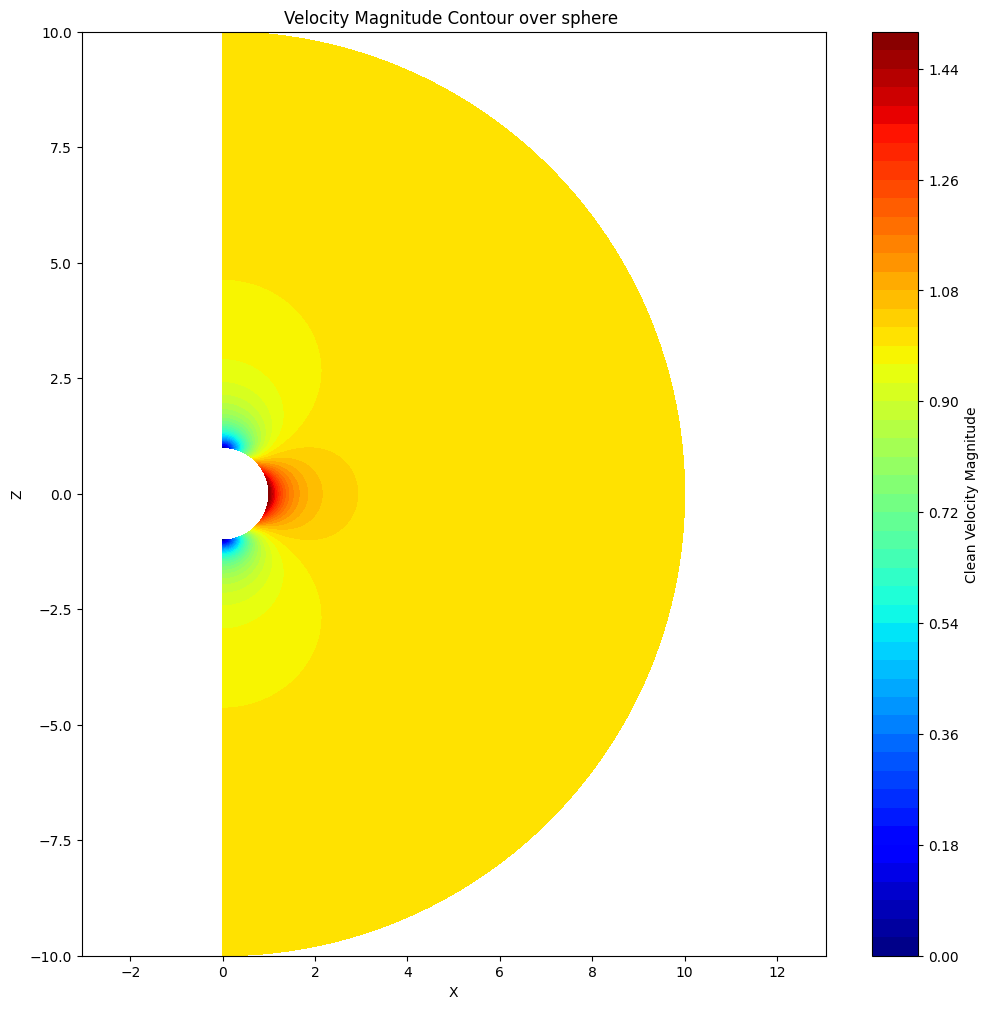

In [9]:
plt.figure(figsize=(12, 12))
plt.contourf(torch.reshape(X,(num_points_r,num_points_theta)).detach().numpy(), torch.reshape(Z,(num_points_r,num_points_theta)).detach().numpy(), torch.reshape(torch.abs(V),(num_points_r,num_points_theta)).detach().numpy(), levels=50, cmap='jet')
plt.colorbar(label='Clean Velocity Magnitude')
plt.title(r'Velocity Magnitude Contour over sphere ')
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')


(-8.74227794156468e-07, 9.999692916870117, -10.0, 10.0)

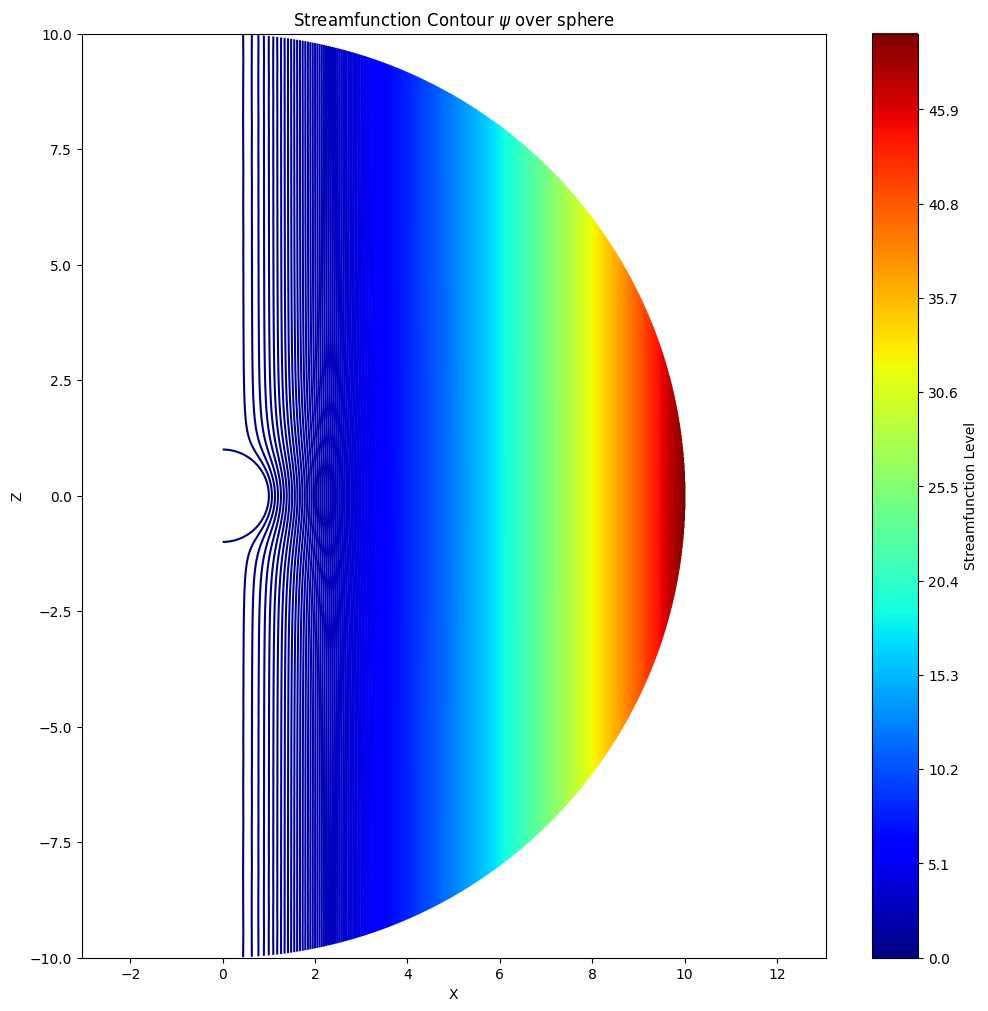

In [10]:
plt.figure(figsize=(12, 12))
plt.contour(torch.reshape(X,(num_points_r,num_points_theta)).detach().numpy(), torch.reshape(Z,(num_points_r,num_points_theta)).detach().numpy(), torch.reshape(torch.abs(psi),(num_points_r,num_points_theta)).detach().numpy(), levels=500, cmap='jet')
plt.colorbar(label='Streamfunction Level')
plt.title(r'Streamfunction Contour $\psi$ over sphere')
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')


## Generate $$\mathbf{u}\cdot \nabla \mathbf{u}$$

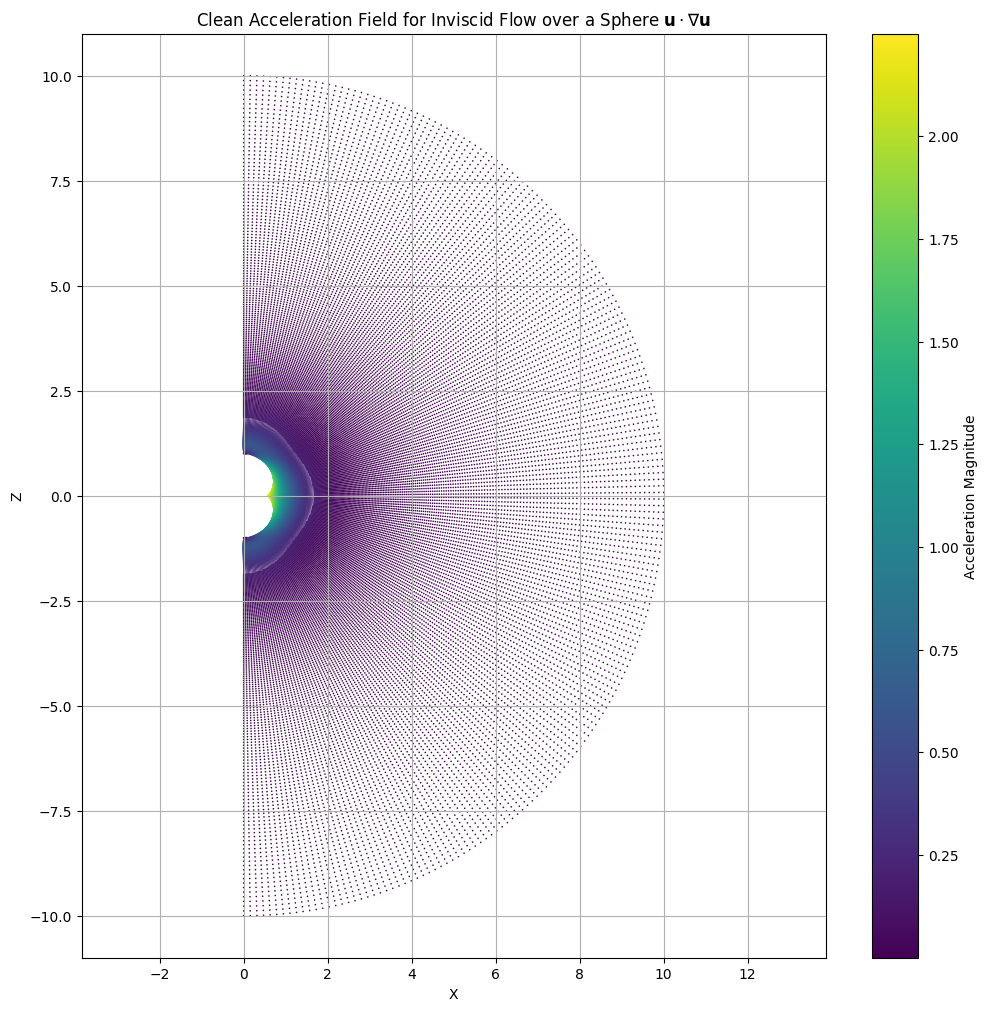

tensor([-2.2500e-08, -5.6780e-04, -2.2564e-03,  ...,  2.9926e-04,
         2.9959e-04,  2.9971e-04], grad_fn=<SubBackward0>)
tensor([ 2.2500e-04,  3.5738e-02,  7.1216e-02,  ..., -9.4634e-06,
        -4.7340e-06,  2.6220e-11], grad_fn=<AddBackward0>)


In [11]:
a_x,a_z,convective_r,convective_theta,A=spherical_acceleration_field(R,Theta,V_r,V_theta)
# Plot acceleration field
plt.figure(figsize=(12, 12))
plt.quiver(X.detach().numpy(), Z.detach().numpy(), a_x.detach().numpy(), a_z.detach().numpy(), A.detach().numpy(),angles='xy', scale_units='xy', scale=5, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title(r'Clean Acceleration Field for Inviscid Flow over a Sphere $\mathbf{u} \cdot \nabla \mathbf{u}$')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Acceleration Magnitude")
plt.show()


print(convective_r)
print(convective_theta)

(-8.74227794156468e-07, 9.999692916870117, -10.0, 10.0)

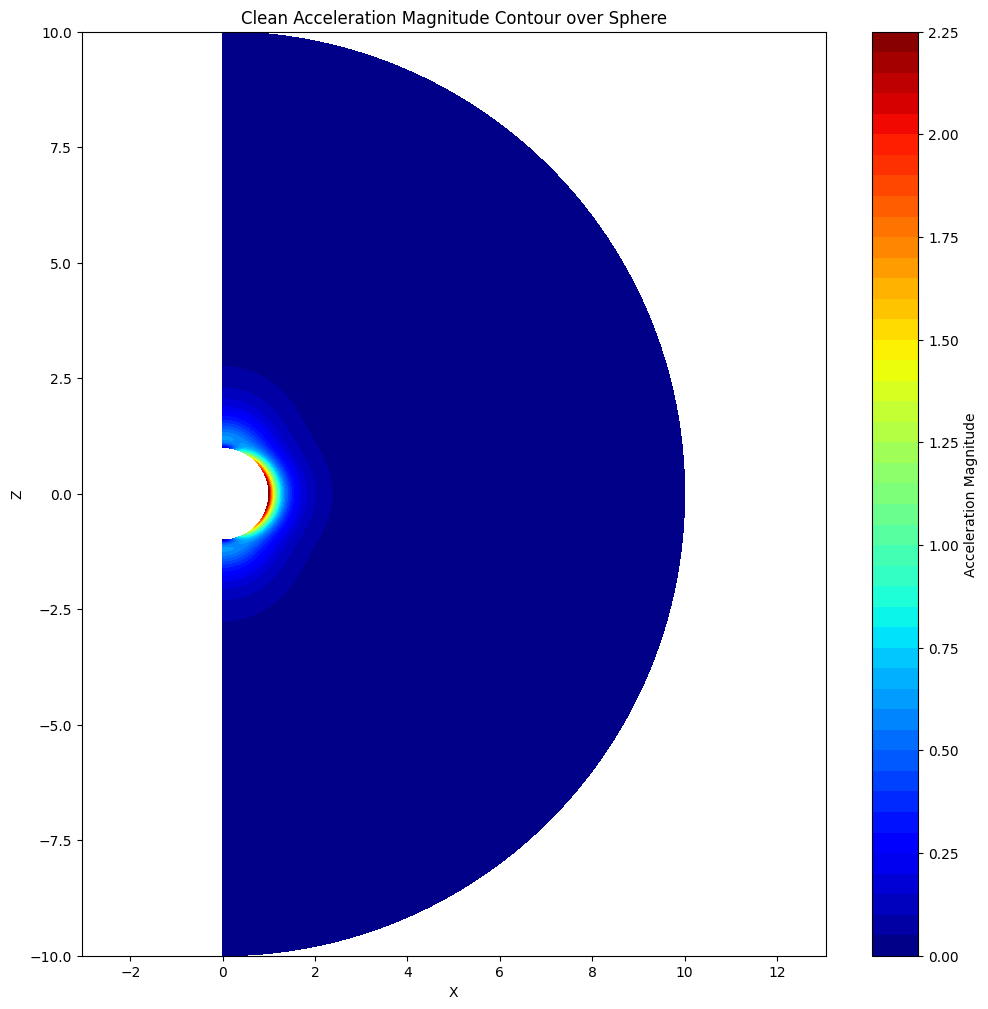

In [12]:
plt.figure(figsize=(12, 12))
plt.contourf(torch.reshape(X,(num_points_r,num_points_theta)).detach().numpy(), torch.reshape(Z,(num_points_r,num_points_theta)).detach().numpy(), torch.reshape(torch.abs(A),(num_points_r,num_points_theta)).detach().numpy(), levels=50, cmap='jet')
plt.colorbar(label='Acceleration Magnitude')
plt.title(r'Clean Acceleration Magnitude Contour over Sphere')
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')


## Appellian Integration

$$\int_{0}^{\pi} \int_{R}^{\infty} \Big((\mathbf{u} \cdot \nabla) \mathbf{u}\Big)^2 r^2 sin\theta dr  d\mathbf{\theta}$$



tensor(5286.3423, grad_fn=<SumBackward0>)
Integral over the polar area: 1.105355978012085


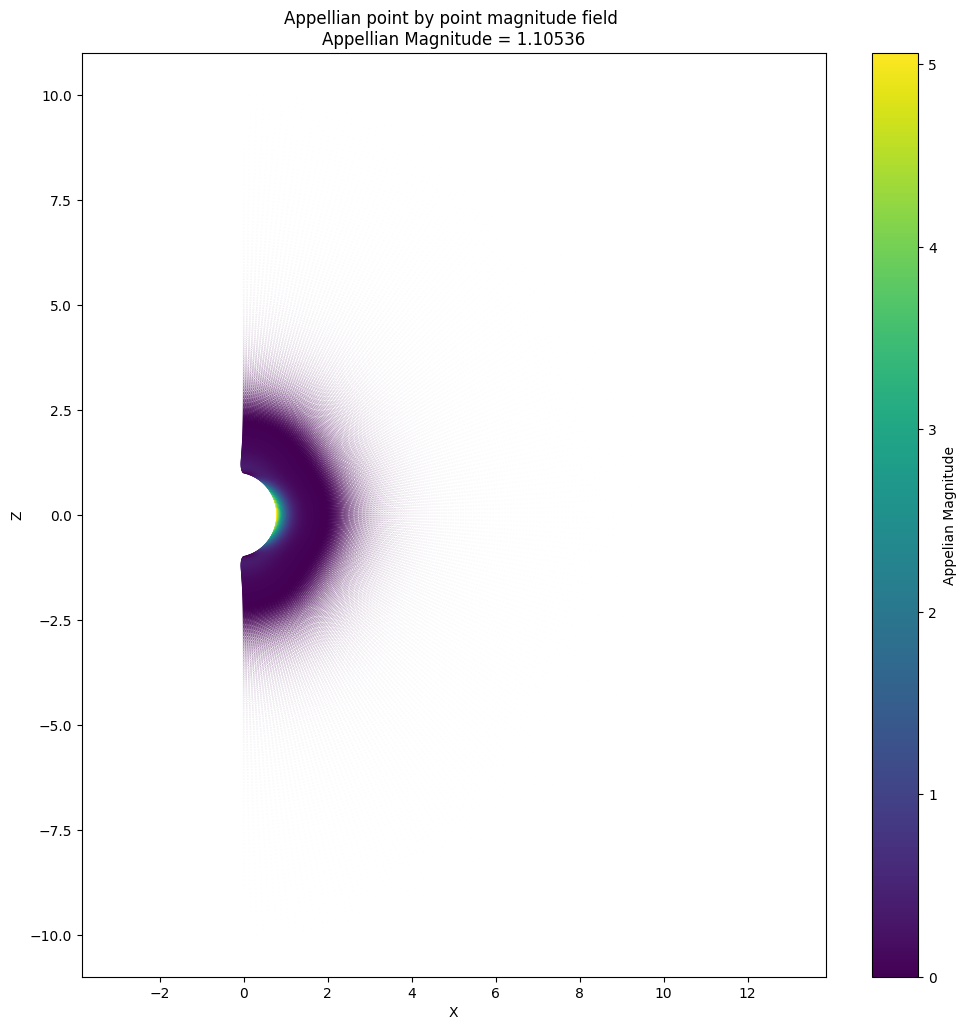

In [13]:
I=convective_r**2 + convective_theta**2

print(torch.sum(I))

Appellian= integrate_r_theta_spherical_axis_symmetric(I,r_values,theta_values,num_points_theta,num_points_r)
print("Integral over the polar area:", Appellian)

plt.figure(figsize=(12, 12))
plt.scatter(X.detach().numpy(), Z.detach().numpy(), s=30*I.detach().numpy(), c=I.detach().numpy(), cmap='viridis')
plt.title(f'Appellian point by point magnitude field \nAppellian Magnitude = {Appellian:.5f}')
cbar = plt.colorbar()
cbar.set_label("Appelian Magnitude")
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

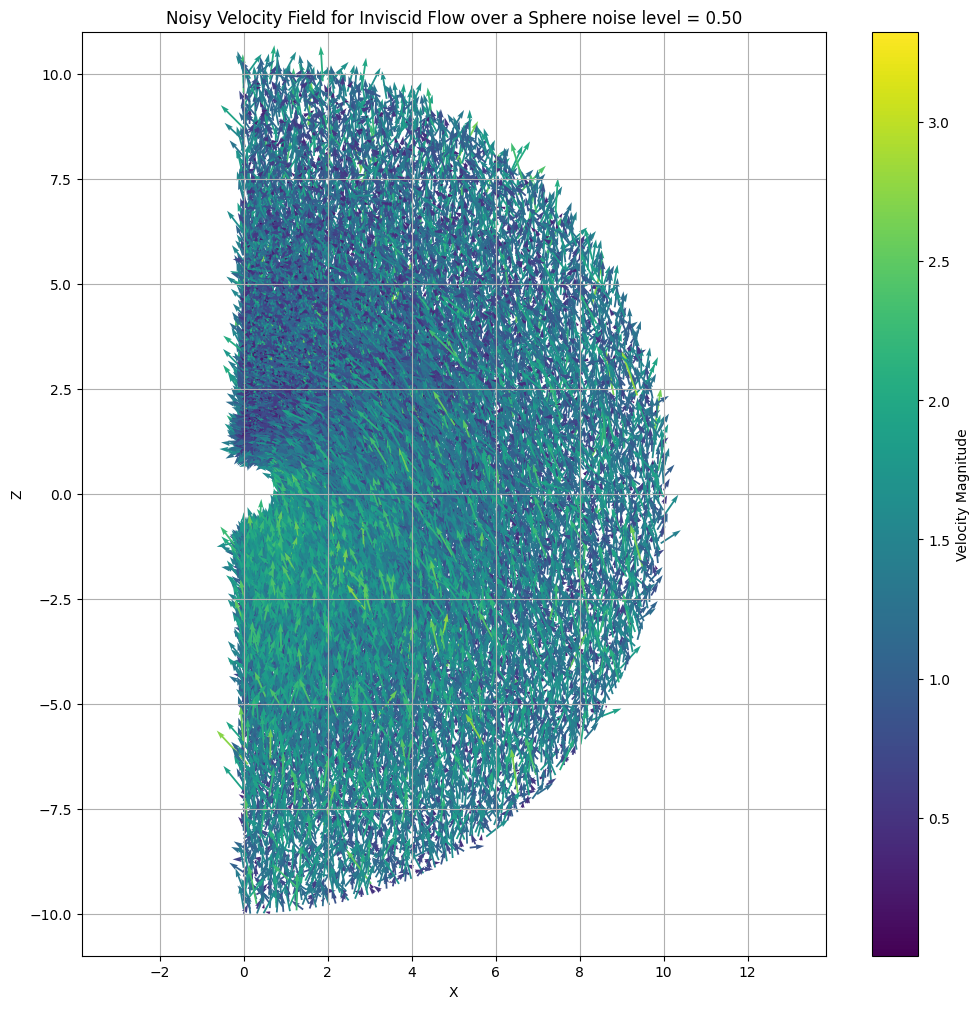

In [14]:
plt.figure(figsize=(12, 12))
plt.quiver(X.detach().numpy(), Z.detach().numpy(), u_x_noise.detach().numpy(), u_z_noise.detach().numpy(), V_noise.detach().numpy(),angles='xy', scale_units='xy', scale=2.5, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Noisy Velocity Field for Inviscid Flow over a Sphere noise level = 'f'{noise_level:.2f}')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Velocity Magnitude")
plt.show()


In [15]:
def calculate_errors(u_x, u_z, u_x_noise, u_z_noise):
    errors1 = u_x_noise - u_x
    errors2 = u_z_noise - u_z

    mean_error1 = torch.mean(errors1).item()
    rms_error1 = torch.sqrt(torch.mean(errors1**2)).item()
    max_error1 = torch.max(torch.abs(errors1)).item()

    mean_error2 = torch.mean(errors2).item()
    rms_error2 = torch.sqrt(torch.mean(errors2**2)).item()
    max_error2 = torch.max(torch.abs(errors2)).item()

    total_mean_error = torch.mean(torch.cat([errors1, errors2])).item()
    total_rms_error = torch.sqrt(torch.mean(torch.cat([errors1**2, errors2**2]))).item()
    total_max_error = torch.max(torch.abs(torch.cat([errors1, errors2]))).item()

    return total_mean_error, total_rms_error, total_max_error

mean_error, rms_error, max_error = calculate_errors(u_x, u_z,u_x_noise, u_z_noise)
print(rms_error)


0.5016852021217346


In [16]:
#Export tensors
torch.save({
    'R': R,
    'Theta': Theta,
    'V_theta': V_theta,
    'V_r': V_r,
    'V_theta_noise':V_theta_noise,
    'V_r_noise':V_r_noise,
    'noise_level':noise_level
}, 'Velocity_fields.pt')



## Nerual Network for $$ \psi'$$

In [17]:
# Define the neural network model
class StreamfunctionModel(nn.Module):
    def __init__(self):
        super(StreamfunctionModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            # nn.Linear(50, 50),
            # nn.Tanh(),
            # nn.Linear(50, 50),
            # nn.Tanh(),
            # nn.Linear(50, 50),
            # nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1),

        )

    def forward(self, x):
        return self.layers(x)

streamfunction_model = StreamfunctionModel()
streamfunction_model = streamfunction_model.to(device)

In [18]:
def data_loss(streamfunction_model, x_data ,V_r_noise,V_theta_noise):
    psid = streamfunction_model(x_data)
    dpsid = torch.autograd.grad(psid.sum(), x_data, create_graph=True,retain_graph=True )[0]

    dpsid_dr = dpsid [:,0]
    dpsid_dt = dpsid [:,1]

    u_r_pred = 2*dpsid_dt / x_data[:,0]**2
    u_t_pred = -dpsid_dr / x_data[:,0] 

    data_loss = torch.mean((u_r_pred - V_r_noise)**2+(u_t_pred - V_theta_noise)**2)

    return data_loss

## Generate boundary points

In [19]:
def generate_sphere_surface(num_points_theta,radius, theta_max):
    theta_boundary = torch.linspace(0.01, theta_max, num_points_theta)
    r_boundary = radius*torch.ones_like(theta_boundary)
    
# Convert to Cartesian coordinates with assumption phi equal zero
    X_boundary = r_boundary * np.sin(theta_boundary) #Notice different than cylindrical
    Z_boundary = r_boundary * np.cos(theta_boundary)
    
    # r_boundary=torch.tensor(r_boundary, dtype=torch.float32, requires_grad=True)
    # theta_boundary=torch.tensor(theta_boundary, dtype=torch.float32, requires_grad=True)
    # Phi=torch.tensor(Phi, dtype=torch.float32, requires_grad=True)
    # r_boundary=r_boundary.flatten()#.unsqueeze(1)
    # theta_boundary=theta_boundary.flatten()#.unsqueeze(1)
    # # Phi=Phi.flatten()#.unsqueeze(1)
    # X_boundary=X_boundary.flatten()#.unsqueeze(1)
    # Z_boundary=Z_boundary.flatten()#.unsqueeze(1)
    positions = np.column_stack([X_boundary, Z_boundary])
    x_tensor = torch.stack([r_boundary.flatten(), theta_boundary.flatten()],dim=1)
    x_tensor = torch.tensor(x_tensor, dtype=torch.float32)
    return positions, x_tensor


/tmp/ipykernel_1226577/434786116.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x_tensor, dtype=torch.float32)


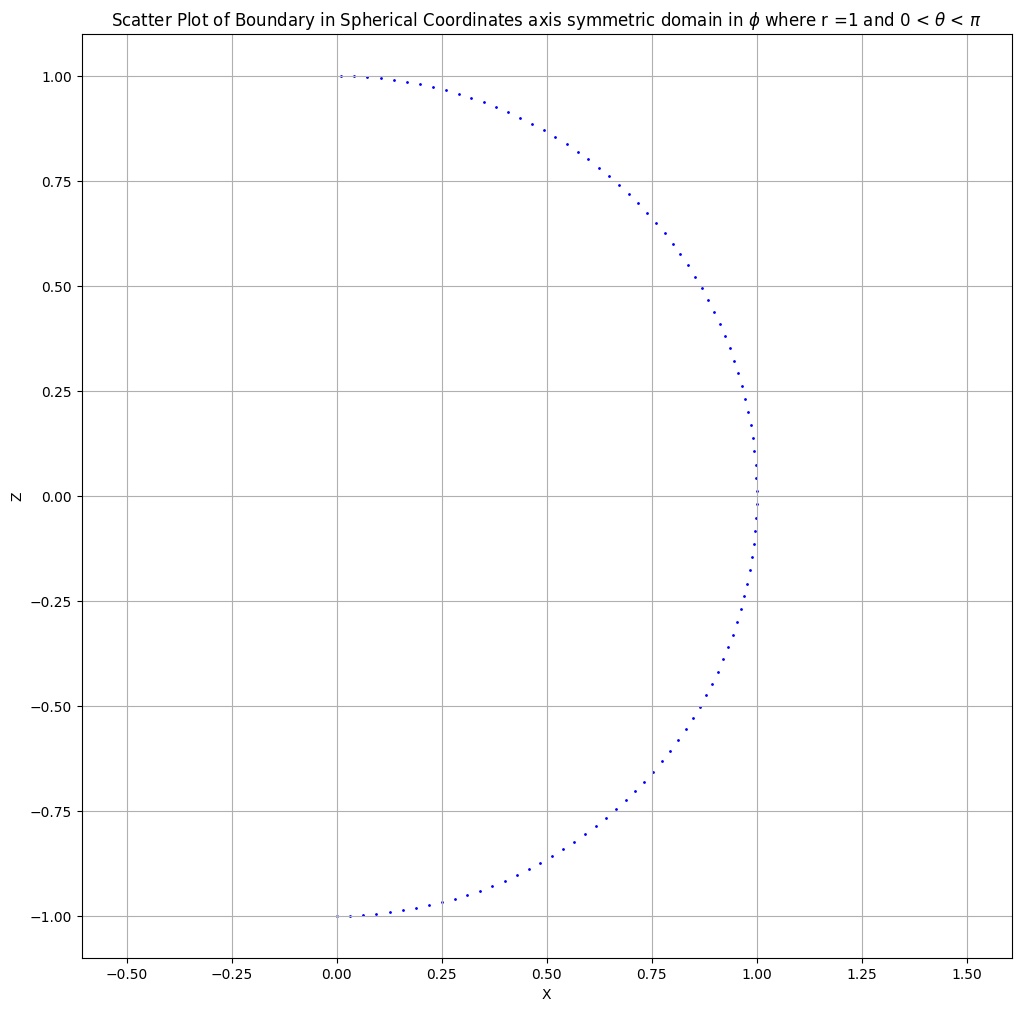

In [20]:
#Boundary for no penetration

# r_boundary, theta_boundary,X_boundary, Z_boundary=generate_sphere_surface(100,1, torch.pi)
# R_theta_boundary=torch.stack([r_boundary, theta_boundary], dim=1)
# x_data_boundary=torch.tensor(R_theta_boundary,dtype=torch.float32, requires_grad=True)

points_boundary, x_data_boundary=generate_sphere_surface(100,1,np.pi)
x_data_boundary=x_data_boundary.to(device).clone().detach()

X_boundary = points_boundary[:,0]
Z_boundary = points_boundary[:,1]

# Create scatter plot
plt.figure(figsize=(12, 12))  # Equal aspect ratio
plt.scatter(X_boundary, Z_boundary, s=1, color='b', marker='o')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Z')
plt.title(r'Scatter Plot of Boundary in Spherical Coordinates axis symmetric domain in $\phi$ where r =1 and 0 < $\theta$ < $\pi$')
plt.grid(True)
plt.show()

/tmp/ipykernel_1226577/434786116.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_tensor = torch.tensor(x_tensor, dtype=torch.float32)


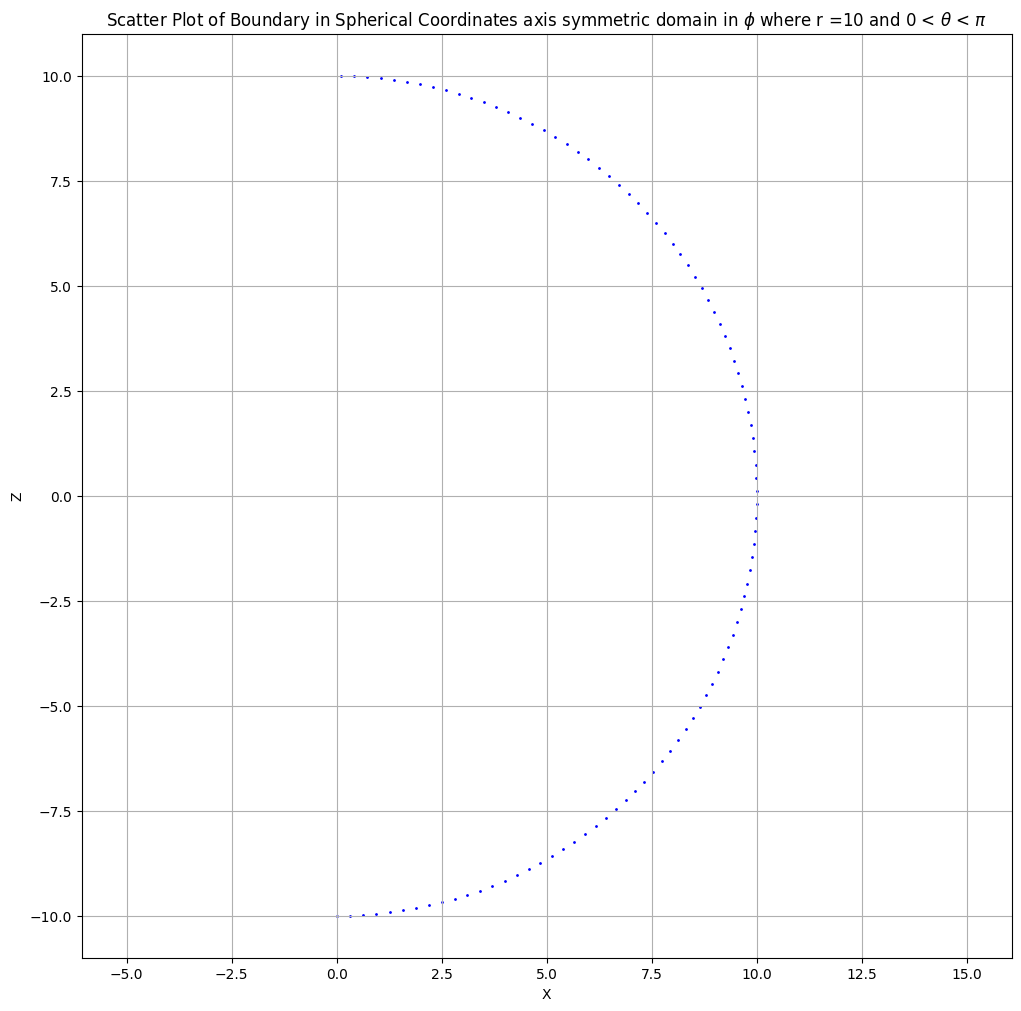

In [21]:
#Freestream points
# r_freestream, theta_freestream,X_freestream, Z_freestream=generate_sphere_surface(100,3, torch.pi)
# R_theta_freestream=torch.stack([r_freestream, theta_freestream], dim=1)
# x_data_freestream=torch.tensor(R_theta_freestream,dtype=torch.float32, requires_grad=True)

points_freestream, x_data_freestream=generate_sphere_surface(100,10,np.pi)
x_data_freestream=x_data_freestream.to(device).clone().detach()
X_freestream = points_freestream[:,0]
Z_freestream = points_freestream[:,1]

points_freestream_5, x_data_freestream_5=generate_sphere_surface(100,5,np.pi)
x_data_freestream_5=x_data_freestream_5.to(device).clone().detach()

# X_freestream = points_freestream[:,0]
# Z_freestream = points_freestream[:,1]


# Create scatter plot
plt.figure(figsize=(12, 12))  # Equal aspect ratio
plt.scatter(X_freestream, Z_freestream, s=1, color='b', marker='o')
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Z')
plt.title(r'Scatter Plot of Boundary in Spherical Coordinates axis symmetric domain in $\phi$ where r =10 and 0 < $\theta$ < $\pi$')
plt.grid(True)
plt.show()

In [22]:
def generate_theta_0_pi(num_points_r, external_radius):
    # Generate points for theta = 0 and theta = pi
    r_values = torch.logspace(torch.log10(torch.tensor(1)), torch.log10(torch.tensor(external_radius)), num_points_r)  # Radial points
    
    # Theta = 0
    theta_0 = torch.zeros_like(r_values)  # theta = 0
    X_boundary_0 = r_values * np.sin(theta_0)  # Should be 0, because sin(0) = 0
    Z_boundary_0 = r_values * np.cos(theta_0)  # Should be r, because cos(0) = 1
    
    # Theta = pi
    theta_pi =  np.pi*torch.ones_like(r_values)  # theta = pi
    X_boundary_pi = r_values * np.sin(theta_pi)  # Should be 0, because sin(pi) = 0
    Z_boundary_pi = r_values * np.cos(theta_pi)  # Should be -r, because cos(pi) = -1
    
    # Stack the positions for theta = 0 and theta = pi
    positions_0 = np.column_stack([X_boundary_0, Z_boundary_0])
    positions_pi = np.column_stack([X_boundary_pi, Z_boundary_pi])
    
    # Create tensors combining r and theta values
    x_tensor_0 = torch.stack([r_values.flatten(), theta_0.flatten()], dim=1)
    x_tensor_pi = torch.stack([r_values.flatten(), theta_pi.flatten()], dim=1)
        
    return positions_0,positions_pi, x_tensor_0,x_tensor_pi


In [23]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

plt.rcParams.update({'font.size': 14})


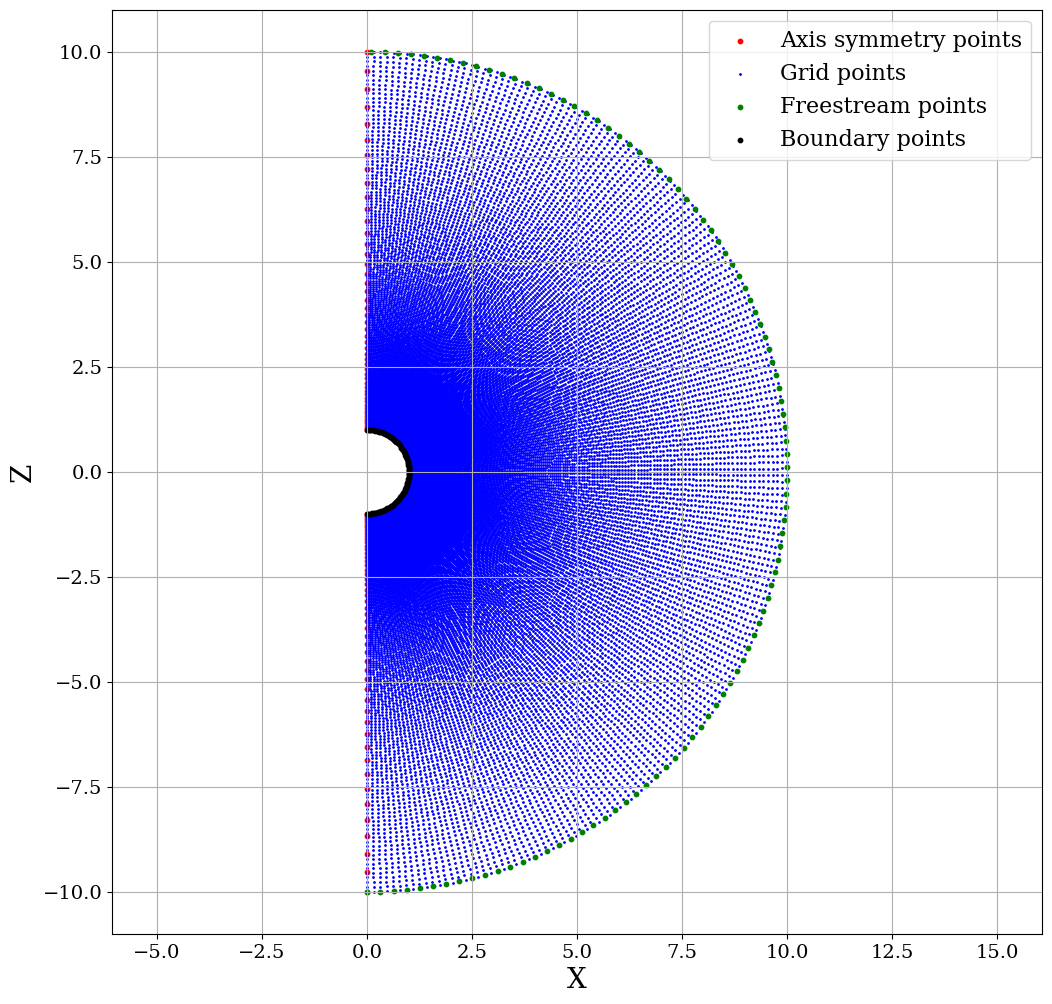

In [24]:
positions_0,positions_pi, x_tensor_0,x_tensor_pi=generate_theta_0_pi(50,10)

X_left_up=positions_0[:,0]
Z_left_up=positions_0[:,1]

X_left_down=positions_pi[:,0]
Z_left_down=positions_pi[:,1]

x_tensor_0=x_tensor_0.to(device).clone().detach()
x_tensor_pi=x_tensor_pi.to(device).clone().detach()

plt.figure(figsize=(12, 12))  # Equal aspect ratio
plt.scatter([X_left_up,X_left_down], [Z_left_up,Z_left_down], s=10, color='r', marker='o',label='Axis symmetry points')
# plt.scatter(, , s=10, color='r', marker='o',label='Axis symmetry points')
plt.scatter(X.flatten(), Z.flatten(), s=1, color='b', marker='o',label='Grid points')
plt.scatter(X_freestream, Z_freestream, s=10, color='g', marker='o',label='Freestream points')
plt.scatter(X_boundary, Z_boundary, s=10, color='black', marker='o',label='Boundary points')


plt.axis('equal')
plt.legend(fontsize=16)
plt.xlabel('X', fontsize=20)
plt.ylabel('Z', fontsize=20)
# plt.title(r'Scatter Plot of Boundary in Spherical Coordinates axis symmetric domain in $\phi$ where r =10 and 0 < $\theta$ < $\pi$')
plt.grid(True)
plt.show()

In [25]:
def no_left_loss_up(streamfunction_model, x_data_left, penalty=1e6):
    x_data_left.requires_grad = True
    psid_left = streamfunction_model(x_data_left)
    dpsid_left = torch.autograd.grad(psid_left.sum(), x_data_left, create_graph=True,retain_graph=True )[0]

    dpsid_dr_left = dpsid_left [:,0]
    dpsid_dt_left = dpsid_left [:,1]

    u_r_left = 2*dpsid_dt_left / x_data_left[:,0]**2
    u_t_left = -dpsid_dr_left / x_data_left[:,0] 
    
    u_x_left = u_r_left * torch.sin(x_data_left[:,1]) + u_t_left * torch.cos(x_data_left[:,1])
    penalty_term = penalty * torch.mean(torch.relu(-u_x_left)**2)  # Penalizes negative u_x_left values
    
    return penalty_term  # Return only the constraint penalty
#This makes sure there is no negative component of u_x on the left boundary

In [26]:
def no_pen_loss(streamfunction_model, x_data_boundary ,penalty=1e6):
    x_data_boundary.requires_grad = True
    psid_boundary = streamfunction_model(x_data_boundary)
    dpsid_boundary = torch.autograd.grad(psid_boundary.sum(), x_data_boundary, create_graph=True,retain_graph=True )[0]

    dpsid_dr_boundary = dpsid_boundary [:,0]
    dpsid_dt_boundary = dpsid_boundary [:,1]

    u_r_boundary = 2*dpsid_dt_boundary / x_data_boundary[:,0]**2
    #u_t_pred_boundary = -dpsid_dr_boundary / x_data_boundary[:,0] 
    
    loss = torch.mean(u_r_boundary**2)
    
    # Add penalty term
    penalty_term = penalty * torch.relu(torch.abs(u_r_boundary) - 0.001)**2
    loss += torch.mean(penalty_term)

    return loss

def farfield_loss(streamfunction_model, x_data_freestream ,penalty=1e6):
    x_data_freestream.requires_grad = True
    psid_freestream = streamfunction_model(x_data_freestream)
    dpsid_freestream = torch.autograd.grad(psid_freestream.sum(), x_data_freestream, create_graph=True,retain_graph=True)[0]

    dpsid_dr_freestream = dpsid_freestream [:,0]
    dpsid_dt_freestream = dpsid_freestream [:,1]

    u_r_freestream = 2*dpsid_dt_freestream / x_data_freestream[:,0]**2
    u_t_freestream = -dpsid_dr_freestream / x_data_freestream[:,0] 
    
    u_x_freestream = u_r_freestream * torch.sin(x_data_freestream[:,1]) + u_t_freestream * torch.cos(x_data_freestream[:,1])
    u_z_freestream = u_r_freestream * torch.cos(x_data_freestream[:,1]) - u_t_freestream * torch.sin(x_data_freestream[:,1])

    loss1 = torch.mean((u_x_freestream - 0)**2)
    loss2 = torch.mean((u_z_freestream - 1)**2)
    
    # Add penalty terms
    penalty_term1 = penalty * torch.relu(torch.abs(u_x_freestream - 0) - 0.001)**2
    penalty_term2 = penalty * torch.relu(torch.abs(u_z_freestream - 1) - 0.001)**2
    loss1 += torch.mean(penalty_term1)
    loss2 += torch.mean(penalty_term2)


    return loss1 + loss2

In [27]:
# def curl_loss(streamfunction_model, x_data,penalty=1e6):
      
#     psi = streamfunction_model(x_data)
#     dpsi = torch.autograd.grad(psi.sum(), x_data, create_graph=True,retain_graph=True)[0]

#     dpsid_dr = dpsi [:,0]
#     dpsid_dt = dpsi [:,1]

#     u_r = 2*dpsid_dt / x_data[:,0]**2
#     u_t = -dpsid_dr / x_data[:,0]
#     dV_r_dr = torch.autograd.grad(u_r.sum(), x_data, create_graph=True, retain_graph=True)[0][:,0]
#     dV_r_dtheta = torch.autograd.grad(u_r.sum(), x_data, create_graph=True, retain_graph=True)[0][:,1]
    
#     dV_theta_dr = torch.autograd.grad(u_t.sum(), x_data, create_graph=True, retain_graph=True)[0][:,0]
#     dV_theta_dtheta = torch.autograd.grad(u_t.sum(), x_data, create_graph=True, retain_graph=True)[0][:,1]
    
    
#     a_r = u_r *dV_r_dr + u_t *dV_r_dtheta / x_data[:,0] - u_t**2 / x_data[:,0]
#     a_t = u_r *dV_theta_dr + u_t *dV_theta_dtheta / x_data[:,0] + u_t * u_r / x_data[:,0]

#     grad_rat_r = torch.autograd.grad((x_data[:,0]*a_t).sum(), x_data,retain_graph=True,create_graph=True)[0][:,0]
#     grad_ar_t = torch.autograd.grad(a_r.sum(), x_data, retain_graph=True,create_graph=True)[0][:,1]

    
#     curl = (grad_rat_r-grad_ar_t)/x_data[:,0]

#     loss = torch.mean(curl**2)
  
# # Add penalty terms
#     penalty_term = penalty * torch.relu(torch.abs(curl) - 0.0001)**2
#     loss += torch.mean(penalty_term)   
    
#     return loss



In [28]:
def curl_loss(streamfunction_model, x_data,penalty=1e6):
      
    psi = streamfunction_model(x_data)
    dpsi = torch.autograd.grad(psi.sum(), x_data, create_graph=True)[0]

    
    dpsi_dr = dpsi[:, 0]
    dpsi_dt = dpsi[:, 1]

    d2psidr = torch.autograd.grad(dpsi_dr.sum(), x_data, retain_graph=True,create_graph=True)[0]
    d2psidt = torch.autograd.grad(dpsi_dt.sum(), x_data, retain_graph=True,create_graph=True)[0]

    dpsidr_dr =d2psidr [:,0]
    dpsidr_dt =d2psidr [:,1]
    dpsidt_dr =d2psidt [:,0]
    dpsidt_dt =d2psidt [:,1]

    a_r= (2*dpsi_dt*(-4*dpsi_dt/x_data[:,0]**3 + 2*dpsidt_dr/x_data[:,0]**2))/x_data[:,0]**2 - (dpsi_dr*2*dpsidt_dt/x_data[:,0]**2)/x_data[:,0]**2 - dpsi_dr**2/x_data[:,0]**3
    a_t= (2*dpsi_dt * (dpsi_dr/x_data[:,0]**2 - dpsidr_dr/x_data[:,0]))/x_data[:,0]**2 + (dpsi_dr* dpsidr_dt/x_data[:,0])/x_data[:,0]**2 - 2*(dpsi_dr*dpsi_dt)/x_data[:,0]**4

    

    grad_rat_r = torch.autograd.grad((x_data[:,0]*a_t).sum(), x_data,retain_graph=True,create_graph=True)[0][:,0]
    grad_ar_t = torch.autograd.grad(a_r.sum(), x_data, retain_graph=True,create_graph=True)[0][:,1]

    
    curl = (grad_rat_r-grad_ar_t)/x_data[:,0]

    loss = torch.mean(curl**2)
  
# Add penalty terms
    penalty_term = penalty * torch.relu(torch.abs(curl) - 0.001)**2
    loss += torch.mean(penalty_term)   
    
    return loss



## Define total cost function

$$\mathcal{L}_{PMPG}=\int_{0}^{\pi} \int_{R}^{\infty} \Big((\mathbf{u} \cdot \nabla) \mathbf{u}\Big)^2 r^2 sin\theta dr  d\mathbf{\theta}$$

$$\mathcal{L}_{NoPenetration} = \mathcal{L}_{NoPenetration} + C  \left( \mathcal{L}_{NoPenetration} - \epsilon\right)^2$$

$$\mathcal{L}_{Farstream} = \mathcal{L}_{Farstream} + C  \left( \mathcal{L}_{Farstream} - \epsilon\right)^2$$

### $$\mathcal{L}_{Total} = \alpha_{1} \mathcal{L}_{data} + \alpha_{2} \mathcal{L}_{NoPenetration} + \alpha_{3} \mathcal{L}_{Farstream} + \alpha_{4} \mathcal{L}_{PMPG} $$


In [29]:
# # Total loss
# alpha1 = 1.0 #data loss
# alpha2 = 1.0 #no penetration
# alpha3 = 1.0 #farstream
# alpha4 = 1.0 #PMPG
# alpha5 = 1.0 #curl
# alpha6 = 1.0 #left_correction

# # Total loss function in addition to the physics loss
# def pinns_loss(streamfunction_model,x_data,V_r_noise,V_theta_noise,x_data_boundary,x_data_freestream,x_tensor_0,x_tensor_pi,r_values,theta_values,num_points_theta,num_points_r,alpha1,alpha2,alpha3,alpha4,alpha5):
    
#     data_loss_val = data_loss(streamfunction_model, x_data , V_r_noise,V_theta_noise)
    
#     nopen_loss_val = no_pen_loss(streamfunction_model, x_data_boundary)
    
#     farfield_loss_val = farfield_loss(streamfunction_model, x_data_freestream)
#     farfield_loss_val2 = farfield_loss(streamfunction_model, x_data_freestream_5)

    
#     curl_loss_val = curl_loss(streamfunction_model, x_data)
    
#     left_correction_val_1= no_left_loss_up(streamfunction_model, x_tensor_0)

#     left_correction_val_2= no_left_loss_up(streamfunction_model, x_tensor_pi)

#     ##Calculate appellian
    
#     psi = streamfunction_model(x_data)
#     dpsi = torch.autograd.grad(psi.sum(), x_data, create_graph=True,retain_graph=True)[0]

#     dpsi_dr = dpsi [:,0]
#     dpsi_dt = dpsi [:,1]

#     # u_r_pred = 2*dpsi_dt / x_data[:,0]**2
#     # u_t_pred = -dpsi_dr / x_data[:,0] 
    
#     d2psidr = torch.autograd.grad(dpsi_dr.sum(), x_data,  retain_graph=True)[0]
#     d2psidt = torch.autograd.grad(dpsi_dt.sum(), x_data,  retain_graph=True)[0]

#     dpsidr_dr =d2psidr [:,0]
#     dpsidr_dt =d2psidr [:,1]
#     dpsidt_dr =d2psidt [:,0]
#     dpsidt_dt =d2psidt [:,1]


#     a_r= (2*dpsi_dt*(-4*dpsi_dt/x_data[:,0]**3 + 2*dpsidt_dr/x_data[:,0]**2))/x_data[:,0]**2 - (dpsi_dr*2*dpsidt_dt/x_data[:,0]**2)/x_data[:,0]**2 - dpsi_dr**2/x_data[:,0]**3
#     a_t= (2*dpsi_dt * (dpsi_dr/x_data[:,0]**2 - dpsidr_dr/x_data[:,0]))/x_data[:,0]**2 + (dpsi_dr* dpsidr_dt/x_data[:,0])/x_data[:,0]**2 - (dpsi_dr*dpsi_dt)/x_data[:,0]**3

#     Integrand = a_r**2 + a_t**2
    
#     pmpg_loss_val= integrate_r_theta_spherical_axis_symmetric(Integrand,r_values,theta_values,num_points_theta,num_points_r)

#     loss = alpha1 * data_loss_val + alpha2 * nopen_loss_val + alpha3 * (farfield_loss_val+farfield_loss_val2) + alpha4*pmpg_loss_val + alpha5*curl_loss_val + alpha6*(left_correction_val_1+left_correction_val_2)
    
#     return loss
# This one is working but the appellian is using modified stream function the next is velocities using modified while the rest is conventional for acceleration

In [30]:
# Total loss
alpha1 = 0.7 #data loss
alpha2 = 0.3 #no penetration
alpha3 = 1.0 #farstream
alpha4 = 1.0 #PMPG
alpha5 = 1.0 #curl
alpha6 = 1.0 #left_correction

# Total loss function in addition to the physics loss
def pinns_loss(streamfunction_model,x_data,V_r_noise,V_theta_noise,x_data_boundary,x_data_freestream,x_tensor_0,x_tensor_pi,r_values,theta_values,num_points_theta,num_points_r,alpha1,alpha2,alpha3,alpha4,alpha5):
    
    data_loss_val = data_loss(streamfunction_model, x_data , V_r_noise,V_theta_noise)
    
    nopen_loss_val = no_pen_loss(streamfunction_model, x_data_boundary)
    
    farfield_loss_val = farfield_loss(streamfunction_model, x_data_freestream)
    farfield_loss_val2 = farfield_loss(streamfunction_model, x_data_freestream_5)

    
    curl_loss_val = curl_loss(streamfunction_model, x_data)
    
    left_correction_val_1= no_left_loss_up(streamfunction_model, x_tensor_0)

    left_correction_val_2= no_left_loss_up(streamfunction_model, x_tensor_pi)

    ##Calculate appellian
    
    psi = streamfunction_model(x_data)
    dpsi = torch.autograd.grad(psi.sum(), x_data, create_graph=True,retain_graph=True)[0]

    dpsid_dr = dpsi [:,0]
    dpsid_dt = dpsi [:,1]

    u_r = 2*dpsid_dt / x_data[:,0]**2
    u_t = -dpsid_dr / x_data[:,0]
    dV_r_dr = torch.autograd.grad(u_r.sum(), x_data, create_graph=True, retain_graph=True)[0][:,0]
    dV_r_dtheta = torch.autograd.grad(u_r.sum(), x_data, create_graph=True, retain_graph=True)[0][:,1]
    
    dV_theta_dr = torch.autograd.grad(u_t.sum(), x_data, create_graph=True, retain_graph=True)[0][:,0]
    dV_theta_dtheta = torch.autograd.grad(u_t.sum(), x_data, create_graph=True, retain_graph=True)[0][:,1]
    
    
    a_r = u_r *dV_r_dr + u_t *dV_r_dtheta / x_data[:,0] - u_t**2 / x_data[:,0]
    a_t = u_r *dV_theta_dr + u_t *dV_theta_dtheta / x_data[:,0] + u_t * u_r / x_data[:,0]


    Integrand = a_r**2 + a_t**2
    
    pmpg_loss_val= integrate_r_theta_spherical_axis_symmetric(Integrand.cpu(),r_values,theta_values,num_points_theta,num_points_r)

    loss = alpha1 * data_loss_val + alpha2 * nopen_loss_val + alpha3 * (farfield_loss_val+farfield_loss_val2) + alpha4*pmpg_loss_val + alpha5*curl_loss_val + alpha6*(left_correction_val_1+left_correction_val_2)
    
    return loss


In [31]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

# Train the neural network
optimizer = optim.Adam(list(streamfunction_model.parameters()),lr=1e-3)

epochs_list = []  # List to store epoch numbers
rmse_list = []  # List to store RMSE values
loss_list = []
pg_list = []
# du_dt_list=[]
# dVn_dt_boundary_list=[]
# gamma_dot_list=[]

# Define paths for saving and loading
streamfunction_model_path = 'streamfunction_model2d.pt'
x_data_path = 'x_data2d.pt'
training_state_path = 'training_state.pt'

# Load previous training state
try:
    checkpoint = torch.load(training_state_path)
    streamfunction_model.load_state_dict(checkpoint['streamfunction_model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    start_epoch = checkpoint['epoch']
    epochs_list = checkpoint['epochs_list']
    loss_list = checkpoint['loss_list']
    rmse_list = checkpoint['rmse_list']

    pg_list = checkpoint.get('pg_list', [])  # Initialize with an empty list if not present
    # du_dt_list = checkpoint.get('du_dt_list',[])
    # dVn_dt_boundary_list = checkpoint.get('dVn_dt_boundary_list',[])
    # gamma_dot_list = checkpoint.get('gamma_dot_list',[])

    print(f"Resuming training from epoch {start_epoch}")

except FileNotFoundError:
    start_epoch = 0
    print("Starting a new training session")
    total_elapsed_time = 0.0  # Initialize total elapsed time


epoch_elapsed_time = 0.0  # Initialize total elapsed time

try:
    for epoch in range(start_epoch, 20000):
        optimizer.zero_grad()

        # Record start time for the epoch
        epoch_start_time = time.time()

        loss =pinns_loss(streamfunction_model,x_data,V_r_noise,V_theta_noise,x_data_boundary,x_data_freestream,x_tensor_0,x_tensor_pi,r_values,theta_values,num_points_theta,num_points_r,alpha1,alpha2,alpha3,alpha4,alpha5)
        loss.backward(retain_graph=True)
        optimizer.step()

        # Calculate elapsed time for the epoch
        epoch_elapsed_time = time.time() - epoch_start_time

        if epoch % 25 == 0:
            # Compute PMPG
                psi = streamfunction_model(x_data)
                dpsi = torch.autograd.grad(psi.sum(), x_data, create_graph=True,retain_graph=True)[0]

                dpsid_dr = dpsi [:,0]
                dpsid_dt = dpsi [:,1]

                u_r = 2*dpsid_dt / x_data[:,0]**2
                u_t = -dpsid_dr / x_data[:,0]
                dV_r_dr = torch.autograd.grad(u_r.sum(), x_data, create_graph=True, retain_graph=True)[0][:,0]
                dV_r_dtheta = torch.autograd.grad(u_r.sum(), x_data, create_graph=True, retain_graph=True)[0][:,1]

                dV_theta_dr = torch.autograd.grad(u_t.sum(), x_data, create_graph=True, retain_graph=True)[0][:,0]
                dV_theta_dtheta = torch.autograd.grad(u_t.sum(), x_data, create_graph=True, retain_graph=True)[0][:,1]


                a_r = u_r *dV_r_dr + u_t *dV_r_dtheta / x_data[:,0] - u_t**2 / x_data[:,0]
                a_t = u_r *dV_theta_dr + u_t *dV_theta_dtheta / x_data[:,0] + u_t * u_r / x_data[:,0]


                Integrand = a_r**2 + a_t**2

                pmpg_loss_val= integrate_r_theta_spherical_axis_symmetric(Integrand.cpu(),r_values,theta_values,num_points_theta,num_points_r)

                psid_pred = streamfunction_model(x_data)
                dpsid_pred = torch.autograd.grad(psid_pred.sum(), x_data, create_graph=True,retain_graph=True)[0]

                dpsid_dr_pred = dpsid_pred [:,0]
                dpsid_dt_pred = dpsid_pred [:,1]

                u_r_pred = 2*dpsid_dt_pred / x_data[:,0]**2
                u_t_pred = -dpsid_dr_pred / x_data[:,0]
            # Compute Error
                mean_error, rms_error, max_error = calculate_errors(V_r, V_theta,u_r_pred.cpu(), u_t_pred.cpu())


            # Print RMSE and training information
                print(f"Epoch {epoch}: Loss = {loss.item()}\n Error : {rms_error}\n PG : {pmpg_loss_val}")

            # Collect the epoch number, pg, du_dt, dun_dt
                epochs_list.append(epoch)
                loss_list.append(loss.item())
                rmse_list.append(rms_error)

                pg_list.append(pmpg_loss_val)
                # du_dt_list.append(du_dt.item())
                # dVn_dt_boundary_list.append(dVn_dt_boundary.item())
                # gamma_dot_list.append(gamma_dot.item())



            # Save the training state
                torch.save({
                    'epoch': epoch + 1,
                    'streamfunction_model_state': streamfunction_model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'epochs_list': epochs_list,
                    'loss_list': loss_list,
                    'rmse_list':rmse_list,
                    'pg_list': pg_list
                    # 'du_dt_list':du_dt_list,
                    # 'dVn_dt_boundary_list':dVn_dt_boundary_list,
                    # 'gamma_dot_list':gamma_dot_list
                }, training_state_path)
                torch.save(streamfunction_model.state_dict(), streamfunction_model_path)

        # Accumulate the total elapsed time
        total_elapsed_time += epoch_elapsed_time

except KeyboardInterrupt:
    print("Training interrupted")

finally:
    # Save the trained model and data
    
    torch.save(streamfunction_model.state_dict(), streamfunction_model_path)

    # Save the total elapsed time
    with open('total_elapsed_time.txt', 'w') as file:
        file.write(str(total_elapsed_time))

Starting a new training session
Epoch 0: Loss = 2007838.625
 Error : 0.7262648344039917
 PG : 0.00035492712049745023
Epoch 25: Loss = 1933708.0
 Error : 0.686180830001831
 PG : 0.0001407061645295471
Epoch 50: Loss = 1817871.5
 Error : 0.6656461954116821
 PG : 0.003116822335869074
Epoch 75: Loss = 1618417.75
 Error : 0.6352329254150391
 PG : 0.030098292976617813
Epoch 100: Loss = 1358179.375
 Error : 0.5978257060050964
 PG : 0.24140305817127228
Epoch 125: Loss = 1140503.875
 Error : 0.5680248737335205
 PG : 0.9911370277404785
Epoch 150: Loss = 1011945.8125
 Error : 0.5458096265792847
 PG : 1.9406187534332275
Epoch 175: Loss = 929076.375
 Error : 0.5186055898666382
 PG : 2.1692235469818115
Epoch 200: Loss = 852523.375
 Error : 0.49261900782585144
 PG : 1.9662986993789673
Epoch 225: Loss = 770692.8125
 Error : 0.4772644340991974
 PG : 1.9317591190338135
Epoch 250: Loss = 690710.0
 Error : 0.45912063121795654
 PG : 1.9187012910842896
Epoch 275: Loss = 613892.0
 Error : 0.44590070843696594


In [32]:

# Create a file name incorporating alpha values
file_name = f'data_free_modified_streamfunction2DSpherical_external_noise{noise_level}.npz'
np.savez(file_name, epochs=epochs_list, loss=loss_list,rmse=rmse_list, pg=pg_list, total_elapsed_time=total_elapsed_time)


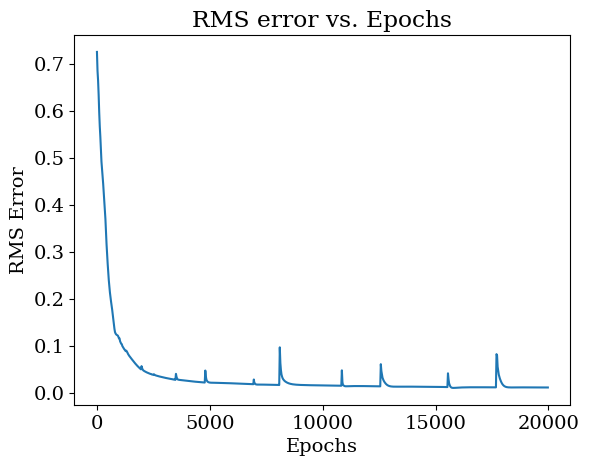

In [33]:
#Plotting of results
plt.figure()
plt.plot(epochs_list, rmse_list)
plt.title(f'RMS error vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMS Error')
plt.show()

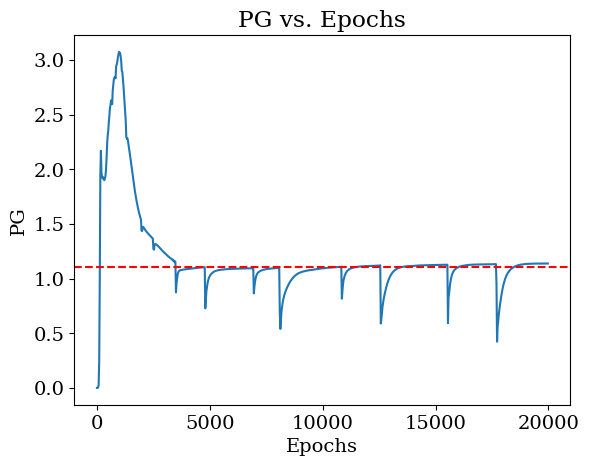

In [34]:
#Plotting of results
plt.figure()
plt.plot(epochs_list[-2800:], pg_list[-2800:])
plt.axhline(y=Appellian, color='r', linestyle='--')
plt.title(f'PG vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('PG')
plt.show()

tensor(1.5118, grad_fn=<MaxBackward1>)


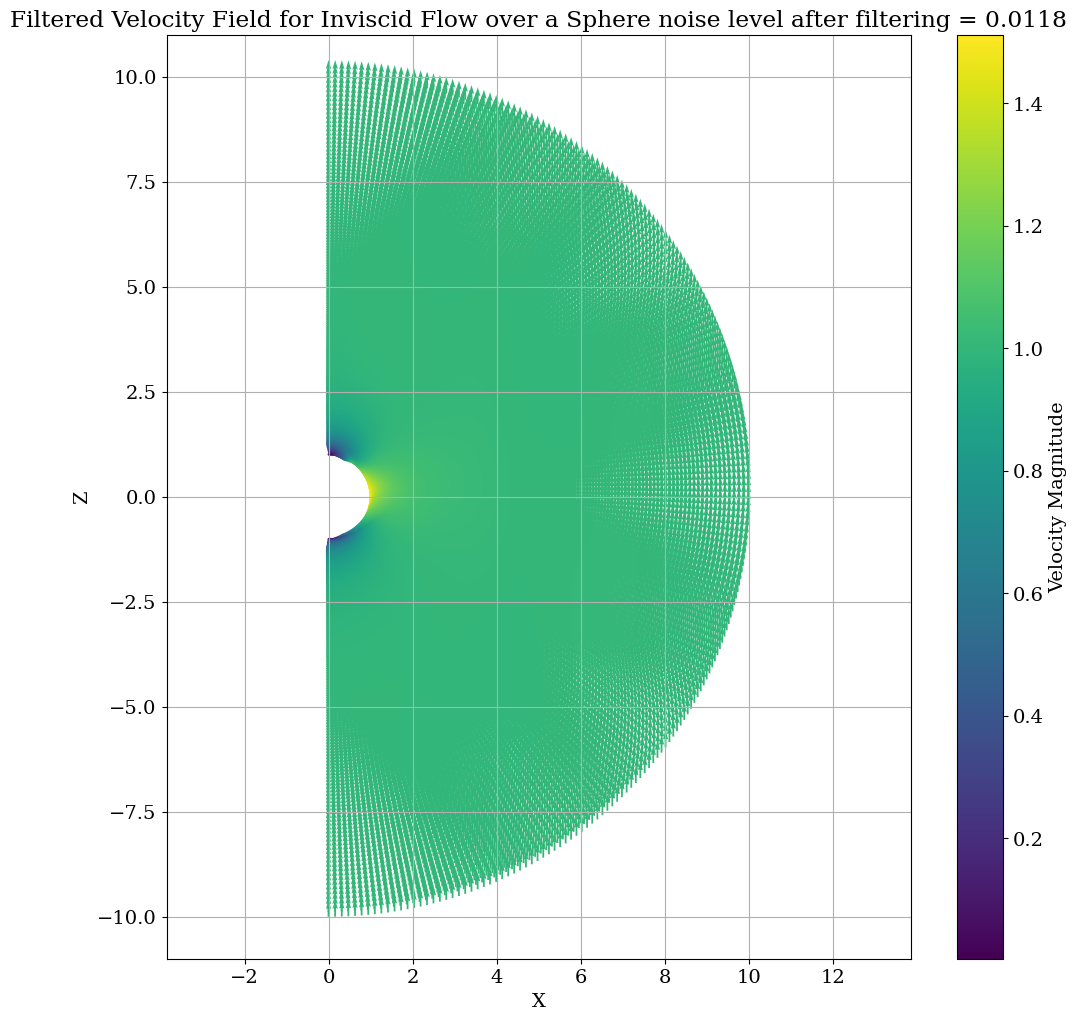

In [35]:
psid_pred = streamfunction_model(x_data)
dpsid_pred = torch.autograd.grad(psid_pred.sum(), x_data, create_graph=True,retain_graph=True)[0]

dpsid_dr_pred = dpsid_pred [:,0]
dpsid_dt_pred = dpsid_pred [:,1]

u_r_pred = 2*dpsid_dt_pred / x_data[:,0]**2
u_t_pred = -dpsid_dr_pred / x_data[:,0]

u_x_pred = u_r_pred.cpu() * torch.sin(Theta) + u_t_pred.cpu() * torch.cos(Theta)
u_z_pred = u_r_pred.cpu() * torch.cos(Theta) - u_t_pred.cpu() * torch.sin(Theta)

V_pred = torch.sqrt(u_x_pred**2+u_z_pred**2)
print(torch.max(V_pred))

# mean_error, rms_error, max_error = calculate_errors(V_r, V_theta,u_r_pred, u_t_pred)

plt.figure(figsize=(12, 12))
plt.quiver(X.detach().numpy(), Z.detach().numpy(), u_x_pred.detach().numpy(), u_z_pred.detach().numpy(), V_pred.detach().numpy(),angles='xy', scale_units='xy', scale=2.5, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Filtered Velocity Field for Inviscid Flow over a Sphere noise level after filtering = 'f'{rms_error:.4f}')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Velocity Magnitude")
plt.show()


In [ ]:
plt.figure(figsize=(12, 12))
plt.contourf(torch.reshape(X,(num_points_r,num_points_theta)).detach().numpy(), torch.reshape(Z,(num_points_r,num_points_theta)).detach().numpy(),torch.reshape(V_pred,(num_points_r,num_points_theta)).detach().numpy(), levels=50, cmap='jet')
plt.xlabel('X')
plt.ylabel('Y')
# plt.title(r'Field of $\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u_{0}} \cdot \nabla) \mathbf{u_{0}}+\frac{\omega^2 R^4}{r^3}\hat{e_r}$'f'\nIntegral Magnitude = {initial_integral:.2f}')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Velocity Magnitude")
plt.show()

In [ ]:
dV_r_dr_pred = torch.autograd.grad(u_r_pred.sum(), x_data, create_graph=True, retain_graph=True)[0][:,0]
dV_r_dtheta_pred = torch.autograd.grad(u_r_pred.sum(), x_data, create_graph=True, retain_graph=True)[0][:,1]
    
dV_theta_dr_pred = torch.autograd.grad(u_t_pred.sum(), x_data, create_graph=True, retain_graph=True)[0][:,0]
dV_theta_dtheta_pred = torch.autograd.grad(u_t_pred.sum(), x_data, create_graph=True, retain_graph=True)[0][:,1]
    
    
convective_r_pred = u_r_pred *dV_r_dr_pred + u_t_pred *dV_r_dtheta_pred / x_data[:,0] - u_t_pred**2 / x_data[:,0]
convective_theta_pred = u_r_pred *dV_theta_dr_pred + u_t_pred *dV_theta_dtheta_pred / x_data[:,0] + u_t_pred* u_r_pred / x_data[:,0]
    
a_x_pred = convective_r_pred * torch.sin(x_data[:,1]) + convective_theta_pred * torch.cos(x_data[:,1])
a_z_pred = convective_r_pred * torch.cos(x_data[:,1]) - convective_theta_pred * torch.sin(x_data[:,1])

A_pred= torch.sqrt(a_x_pred**2 + a_z_pred**2)
# Plot acceleration field
plt.figure(figsize=(12, 12))
plt.quiver(X.detach().numpy(), Z.detach().numpy(), a_x_pred.detach().numpy(), a_z_pred.detach().numpy(), A_pred.detach().numpy(),angles='xy', scale_units='xy', scale=5, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title(r'Acceleration Field for the corrected model a Sphere $\mathbf{u} \cdot \nabla \mathbf{u}$')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Acceleration Magnitude")
plt.show()



In [ ]:
plt.figure(figsize=(12, 12))
plt.contourf(torch.reshape(X,(num_points_r,num_points_theta)).detach().numpy(), torch.reshape(Z,(num_points_r,num_points_theta)).detach().numpy(), torch.reshape(torch.abs(A_pred),(num_points_r,num_points_theta)).detach().numpy(), levels=50, cmap='jet')
plt.colorbar(label='Acceleration Magnitude')
plt.title(r'Filtered Acceleration Magnitude Contour over Sphere')
plt.xlabel('X')
plt.ylabel('Z')
plt.axis('equal')


In [ ]:
I_pred=convective_r_pred**2 + convective_theta_pred**2

print(torch.sum(I_pred))

Appellian_pred= integrate_r_theta_spherical_axis_symmetric(I_pred,r_values,theta_values,num_points_theta,num_points_r)
print("Integral over the polar area:", Appellian_pred)

plt.figure(figsize=(12, 12))
plt.scatter(X.detach().numpy(), Z.detach().numpy(), s=30*I.detach().numpy(), c=I_pred.detach().numpy(), cmap='viridis')
plt.title(f'Filtered Appellian point by point magnitude field \nAppellian Magnitude = {Appellian_pred:.5f}')
cbar = plt.colorbar()
cbar.set_label("Appelian Magnitude")
plt.axis('equal')
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

In [ ]:
x_data_boundary.requires_grad = True
psi_boundary = streamfunction_model(x_data_boundary)

dpsi_boundary = torch.autograd.grad(psi_boundary.sum(), x_data_boundary, create_graph=True,retain_graph=True)[0]

dpsid_dr_boundary = dpsi_boundary [:,0]
dpsid_dt_boundary = dpsi_boundary [:,1]

u_r_boundary = 2*dpsid_dt_boundary / x_data_boundary[:,0]**2
u_t_boundary = -dpsid_dr_boundary / x_data_boundary[:,0]

u_x_boundary = u_r_boundary * torch.sin(x_data_boundary[:,1]) + u_t_boundary * torch.cos(x_data_boundary[:,1])
u_z_boundary = u_r_boundary * torch.cos(x_data_boundary[:,1]) - u_t_boundary * torch.sin(x_data_boundary[:,1])

V_boundary = torch.sqrt(u_x_boundary**2+u_z_boundary**2)

print(f'Maximum ur ={torch.max(u_r_boundary):0.4}')
print(f'Minimum ur ={torch.min(u_r_boundary):0.4}')
print(f'RMS ur ={torch.mean(torch.sqrt(u_r_boundary**2)):0.4}')

plt.figure(figsize=(12, 12))
plt.quiver(X_boundary, Z_boundary, u_x_boundary.detach().numpy(), u_z_boundary.detach().numpy(), V_boundary.detach().numpy(),angles='xy', scale_units='xy', scale=2.5, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Filtered Velocity Field for Inviscid Flow over the boundary mean u_r = 'f'{torch.mean(torch.sqrt(u_r_boundary**2)):.4f}')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Velocity Magnitude")
plt.show()


plt.figure(figsize=(12, 12))
plt.scatter(X_boundary, Z_boundary, s=30*np.abs(u_r_boundary.detach().numpy()),c=np.abs(u_r_boundary.detach().numpy()), cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Filtered Velocity Field for Inviscid Flow over the boundary mean u_r = 'f'{torch.mean(torch.sqrt(u_r_boundary**2)):.4f}')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Velocity Magnitude")
plt.show()



In [ ]:
x_data_freestream.requires_grad = True
psi_freestream = streamfunction_model(x_data_freestream)

dpsi_freestream = torch.autograd.grad(psi_freestream.sum(), x_data_freestream, create_graph=True,retain_graph=True)[0]

dpsid_dr_freestream = dpsi_freestream [:,0]
dpsid_dt_freestream = dpsi_freestream [:,1]

u_r_freestream = 2*dpsid_dt_freestream / x_data_freestream[:,0]**2
u_t_freestream = -dpsid_dr_freestream / x_data_freestream[:,0]



u_x_freestream = u_r_freestream * torch.sin(x_data_freestream[:,1]) + u_t_freestream * torch.cos(x_data_freestream[:,1])
u_z_freestream = u_r_freestream * torch.cos(x_data_freestream[:,1]) - u_t_freestream * torch.sin(x_data_freestream[:,1])

V_freestream = torch.sqrt(u_x_freestream**2+u_z_freestream**2)

print(f'Maximum ux ={torch.max(u_x_freestream):0.4}')
print(f'Minimum ur ={torch.min(u_x_freestream):0.4}')
print(f'RMS ux ={torch.mean(torch.sqrt(u_x_freestream**2)):0.4}')

print(f'Maximum uz ={torch.max(u_z_freestream):0.4}')
print(f'Minimum uz ={torch.min(u_z_freestream):0.4}')
print(f'RMS uz ={torch.mean(torch.sqrt(u_z_freestream**2)):0.4}')

plt.figure(figsize=(12, 12))
plt.quiver(X_freestream, Z_freestream, u_x_freestream.detach().numpy(), u_z_freestream.detach().numpy(), V_freestream.detach().numpy(),angles='xy', scale_units='xy', scale=2.5, cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Filtered Velocity Field for Inviscid Flow over the freestream')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Velocity Magnitude")
plt.show()


plt.figure(figsize=(12, 12))
plt.scatter(X_freestream, Z_freestream, s=30*np.abs(u_x_freestream.detach().numpy()),c=np.abs(u_x_freestream.detach().numpy()), cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Filtered Velocity Field for Inviscid Flow over the freestream mean u_x = 'f'{torch.mean(torch.sqrt(u_x_freestream**2)):.4f}')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Velocity Magnitude")
plt.show()

plt.figure(figsize=(12, 12))
plt.scatter(X_freestream, Z_freestream, s=30*np.abs(u_z_freestream.detach().numpy()),c=np.abs(u_z_freestream.detach().numpy()), cmap='viridis')
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Filtered Velocity Field for Inviscid Flow over the freestream mean u_z = 'f'{torch.mean(torch.sqrt(u_z_freestream**2)):.4f}')
plt.grid(True)
plt.axis('equal')
cbar = plt.colorbar()
cbar.set_label("Velocity Magnitude")
plt.show()


